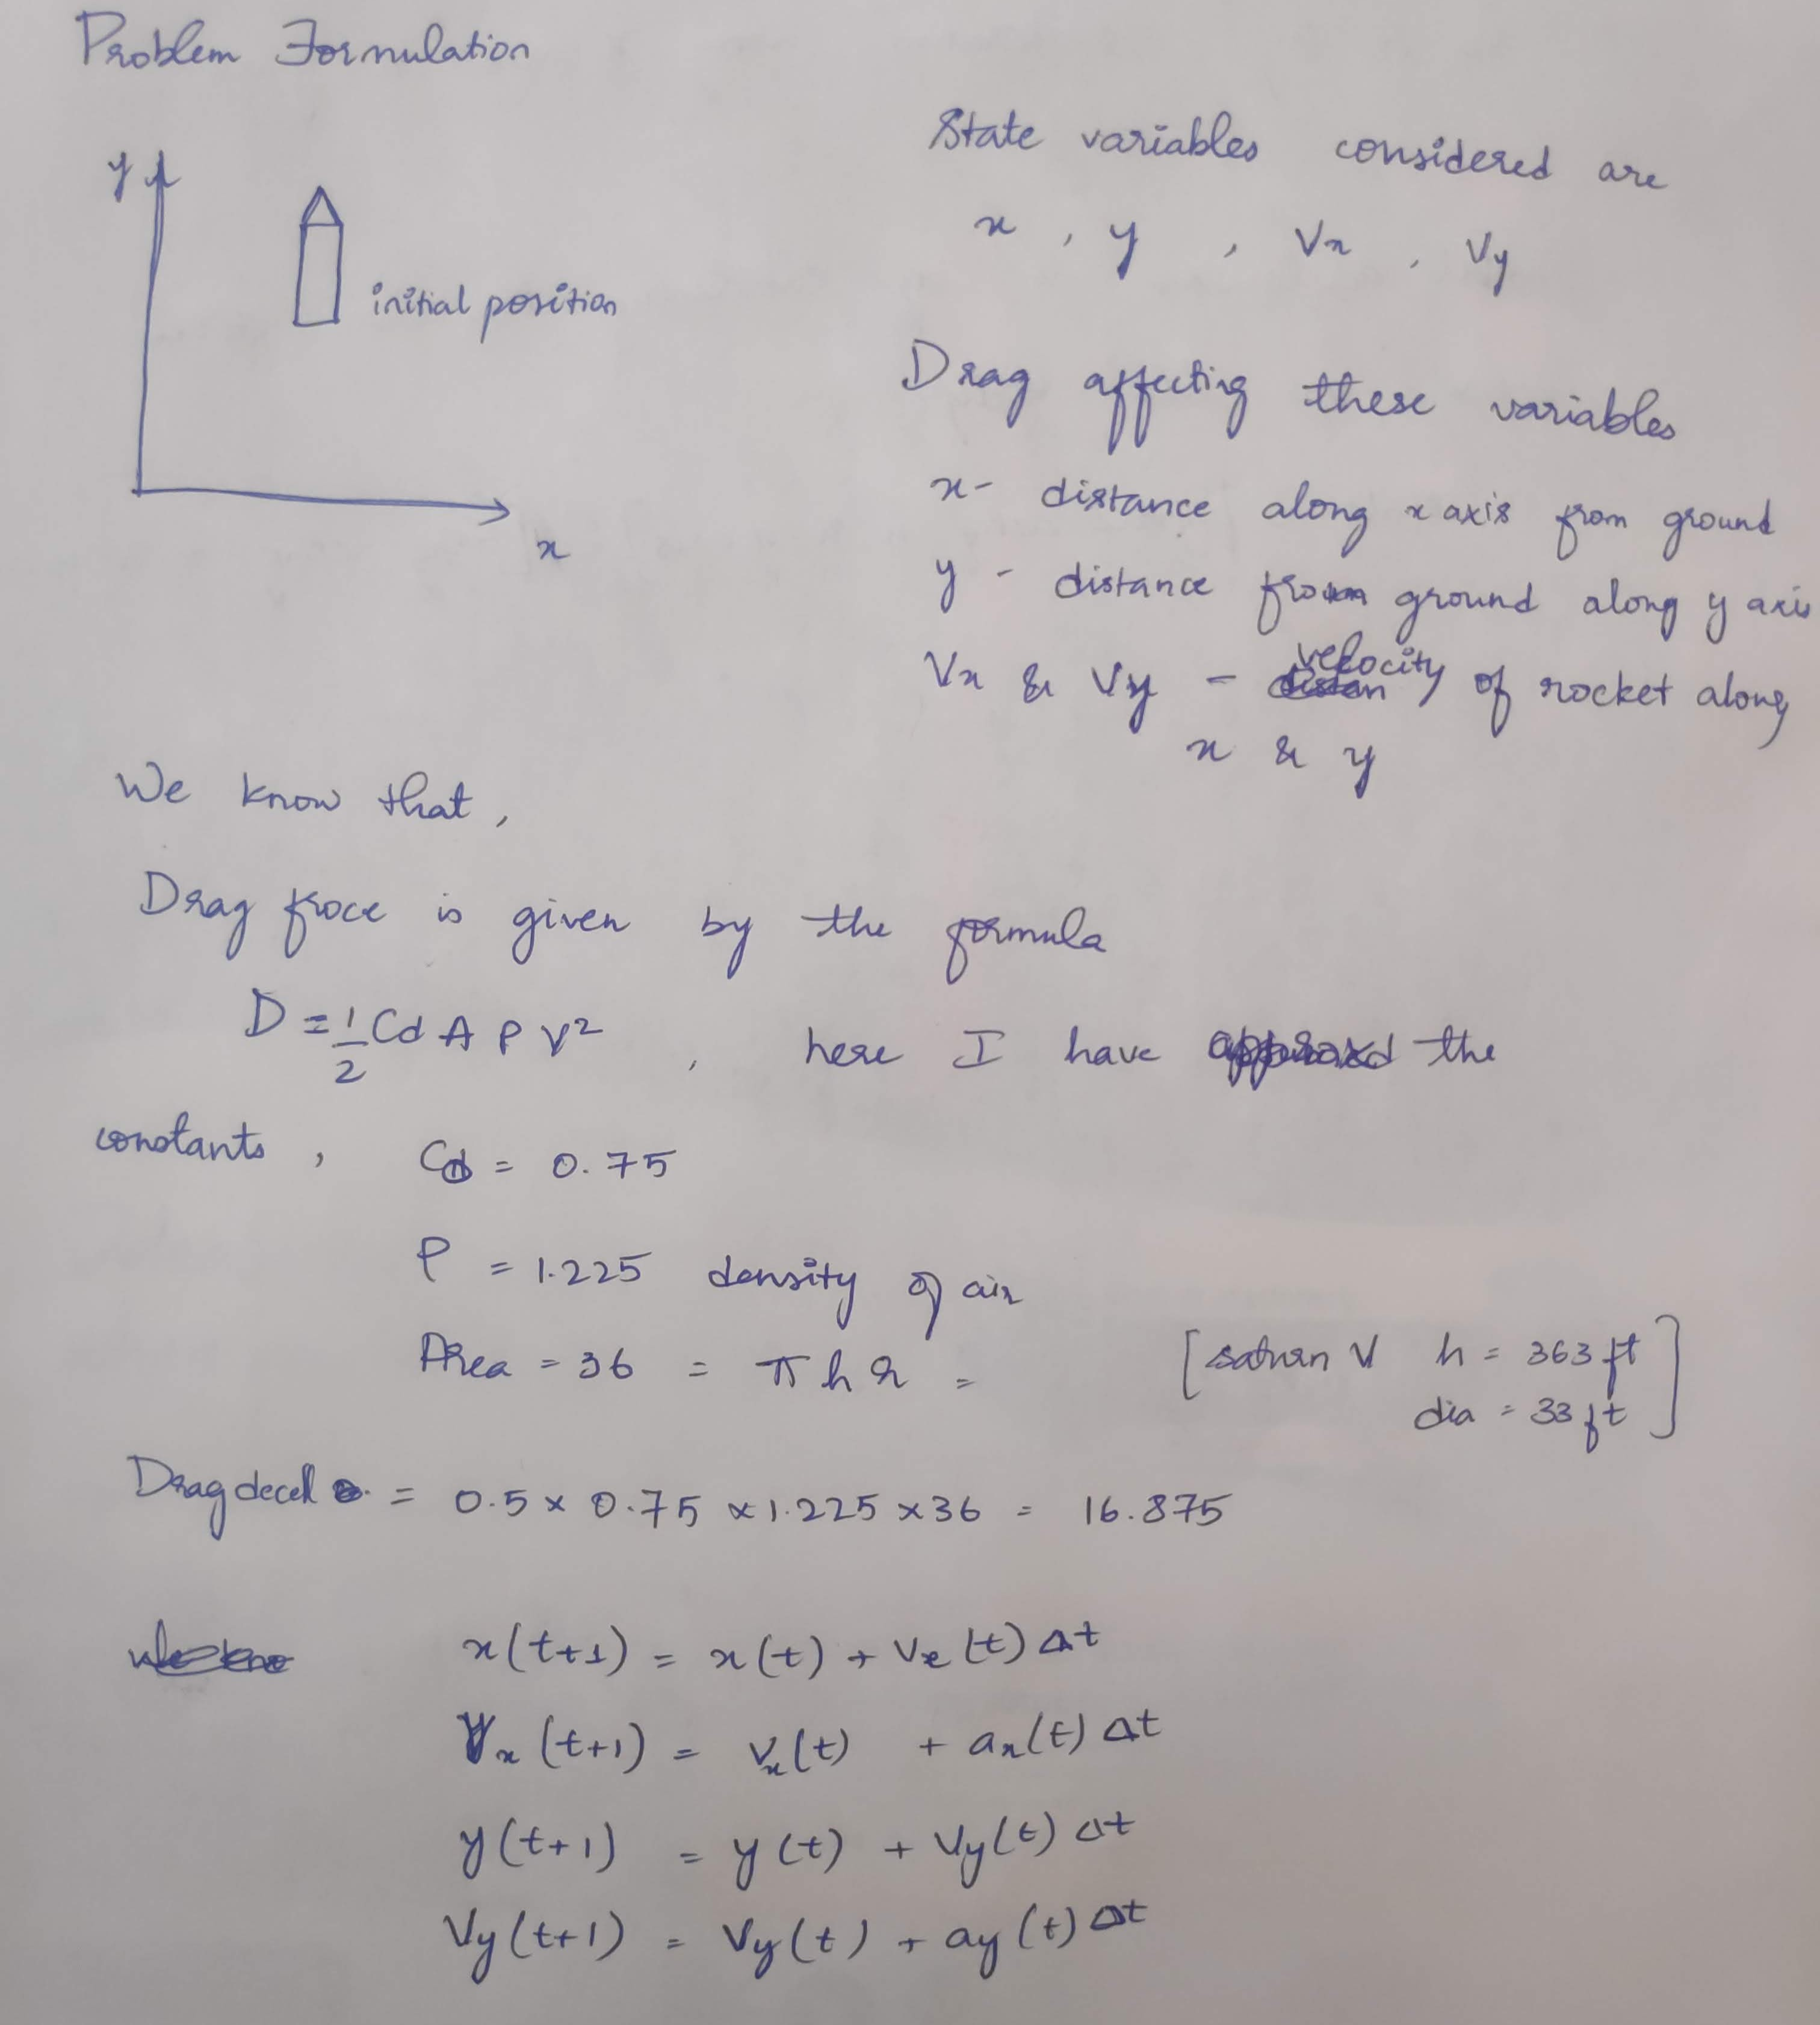

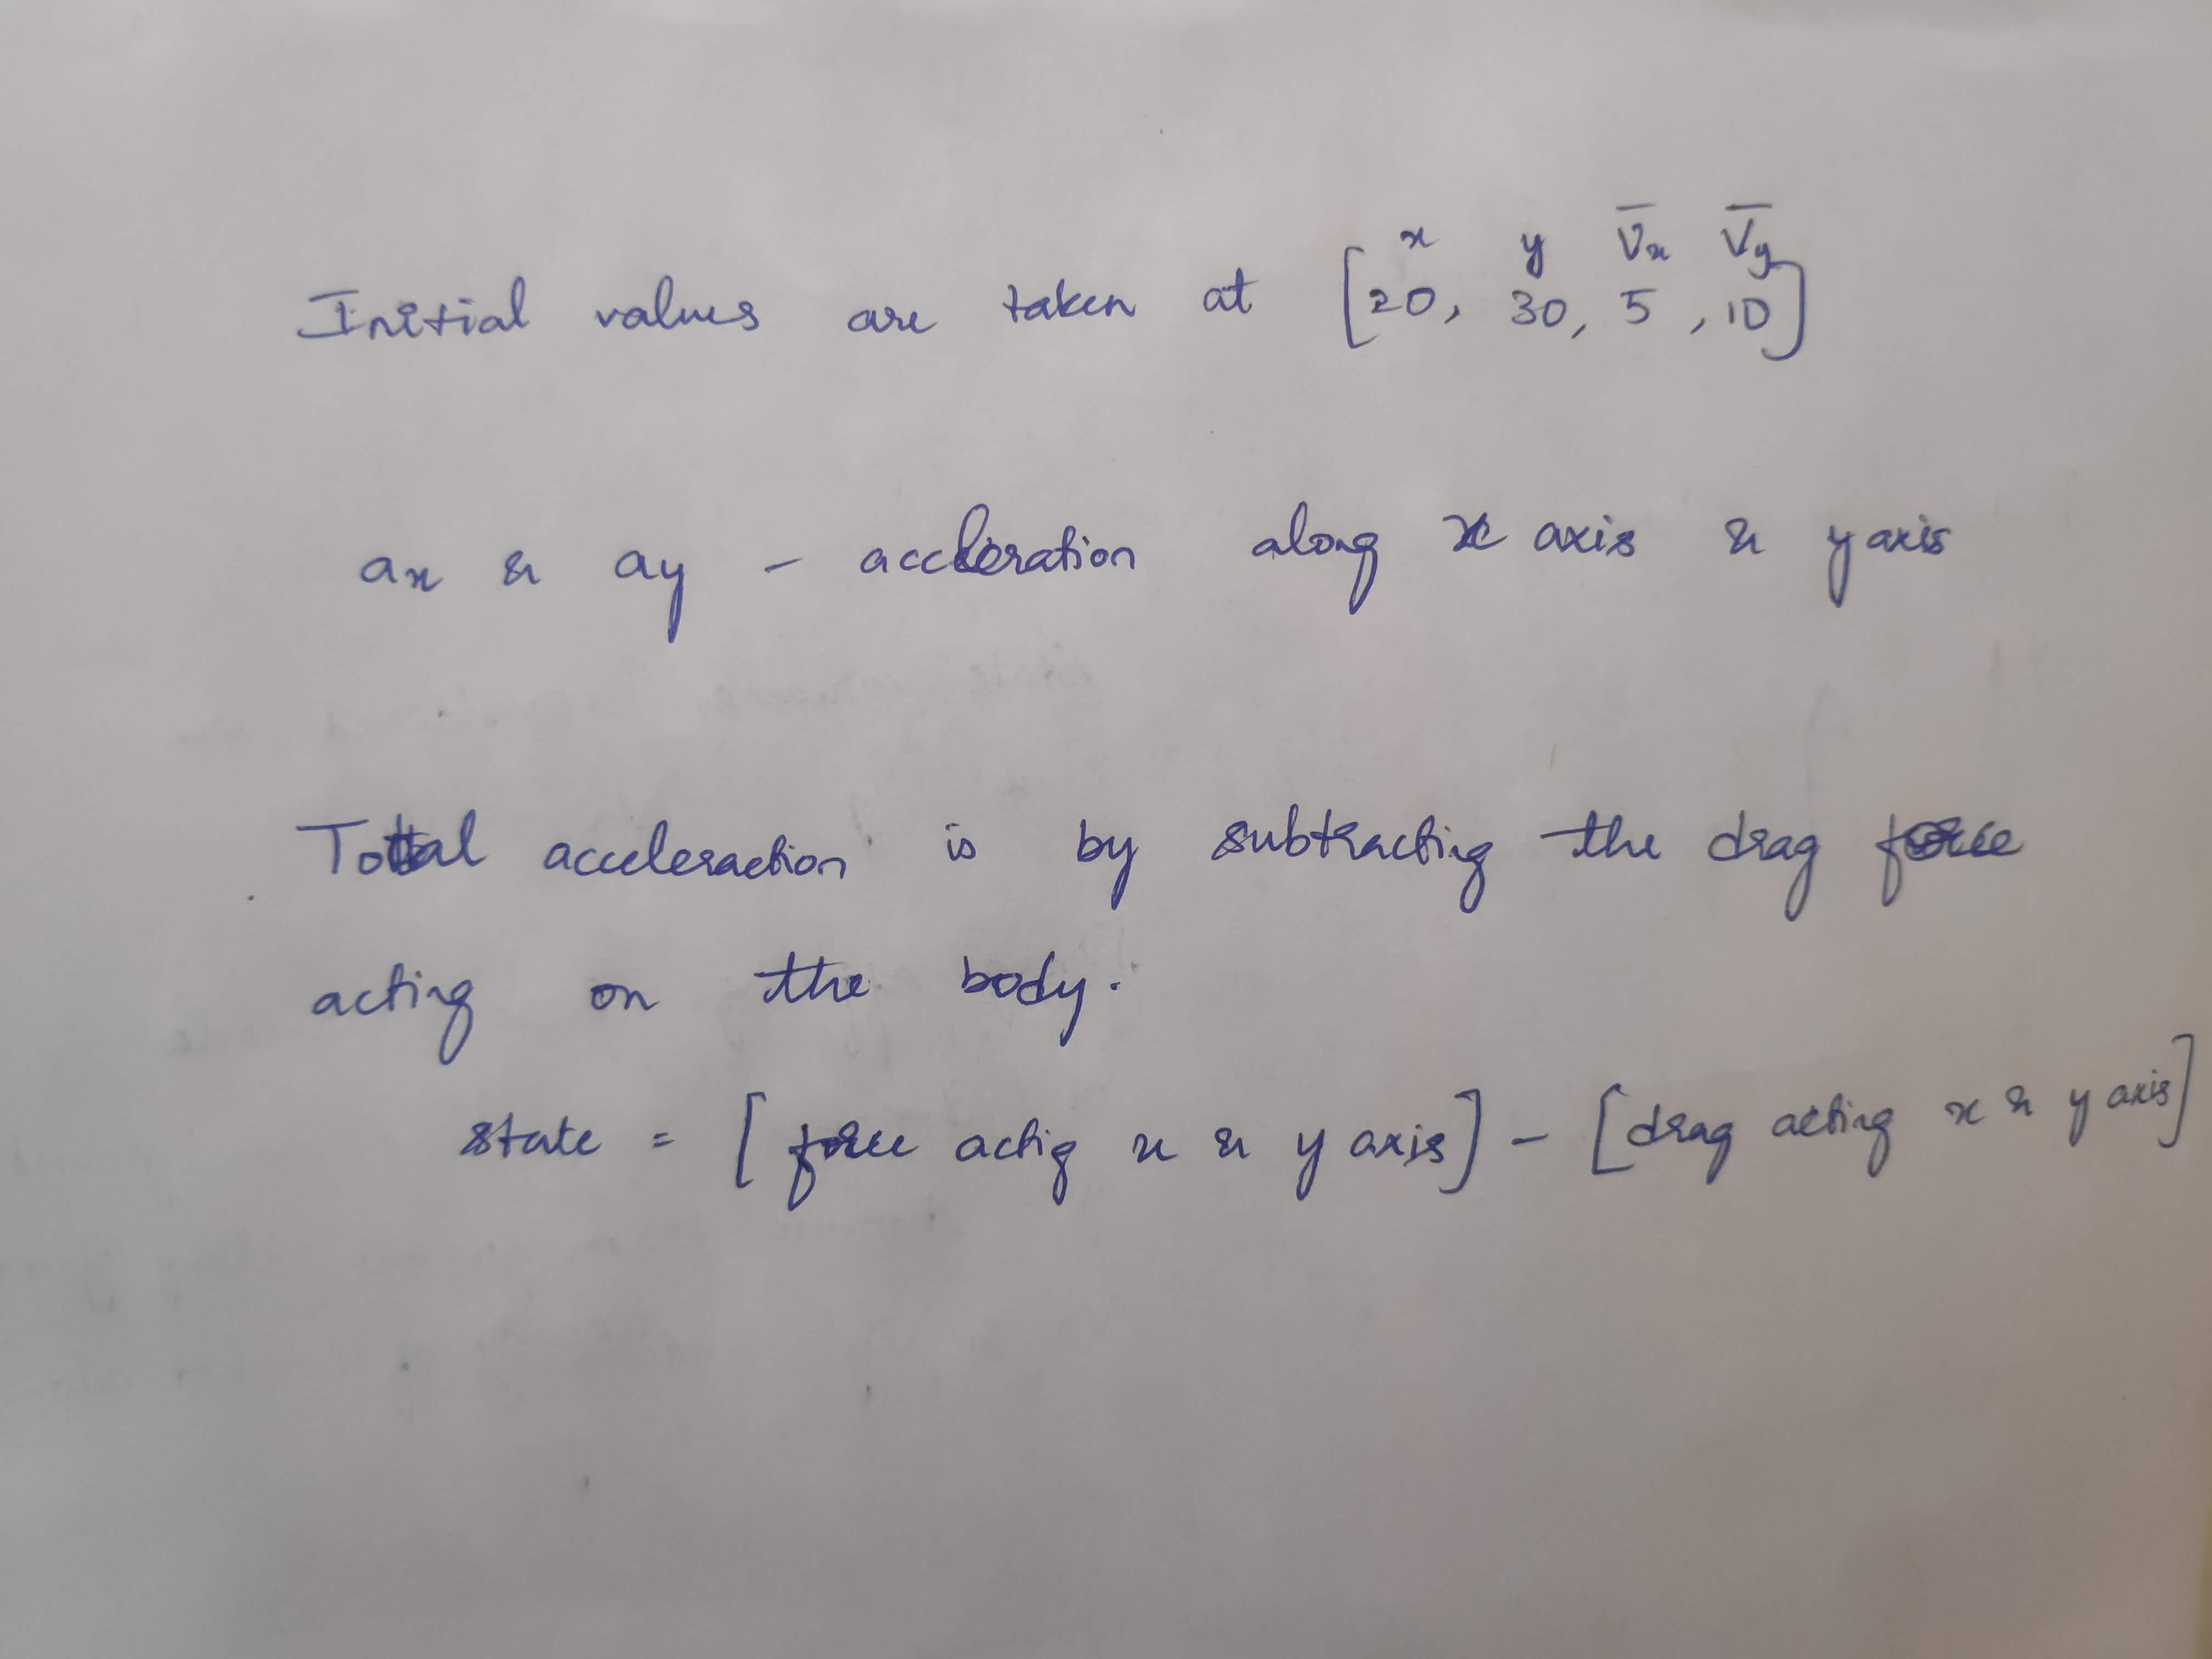

In [1]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.81  # gravity constant
BOOST_ACCEL = 50  # thrust constant
RHO= 1.25
CD = 0.75
AREA = 36
DRAG_DECEL = 16.875  # 0.5*CD*AREA*RHO



In [3]:

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
        
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
      
        delta_state_gravity = t.tensor([0.,0.,0., -GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        # Here considering the drag force affecting the system by subtracting it 
        delta_state = (BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0.,0.,1.]) * action[1]) +  (BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0.,-1.,0.]) * action[0]) - (DRAG_DECEL * FRAME_TIME * t.tensor([0., 0.,0.,1.]) * action[1]) -  (DRAG_DECEL * FRAME_TIME * t.tensor([0., 0.,-1.,0.]) * action[0])


        # Update velocity 
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1.,0., FRAME_TIME,0.],[0.,1.,0.,FRAME_TIME],[0.,0.,1.,0.],[0.,0.,0., 1.]])
        state = t.matmul(step_mat, state)

        #print(action)
        return state

        
       
        


In [4]:


class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden,dim_output),
            
            # You can add more layers here
            nn.Tanh()
        
        )

    def forward(self, state):
        action = self.network(state)
        #print(action)
        return action

    

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [20., 30., 5.,10.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 

In [6]:

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        a = data[:, 2]
        b = data[:, 3]
        
        plt.figure()
        plt.subplot(221)
        plt.title('Distance_X vs Distance_Y plot')
        plt.xlabel('Distance_Y')
        plt.ylabel('Distance_Y')
        plt.plot(x, y)
        
        plt.subplot(222)
        plt.title('Velocity_X vs velocity_Y plot')
        plt.xlabel('Velocity_X')
        plt.ylabel('Velocity_Y')
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()
        

[1] loss: 143308.922


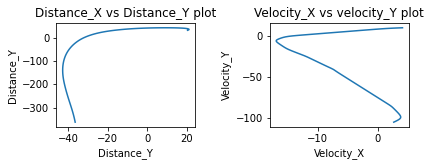

[2] loss: 50486.348


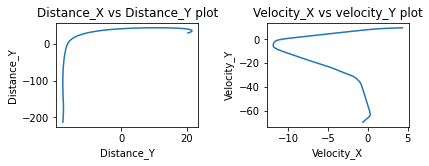

[3] loss: 15619.514


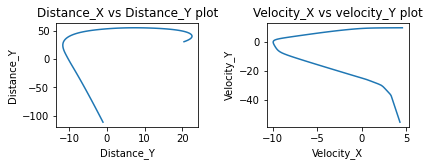

[4] loss: 6527.039


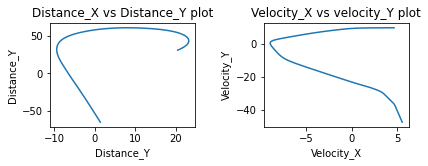

[5] loss: 3751.821


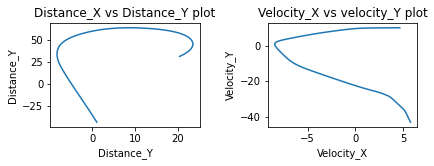

[6] loss: 2545.674


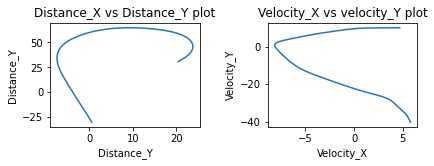

[7] loss: 1900.381


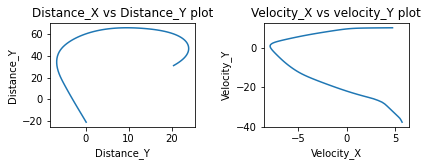

[8] loss: 1497.671


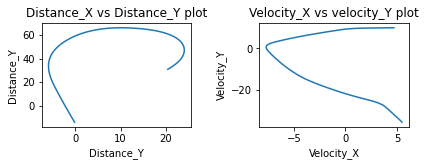

[9] loss: 947.972


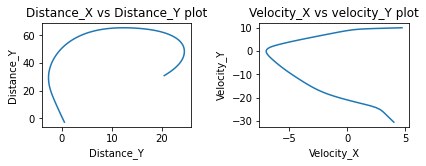

[10] loss: 682.331


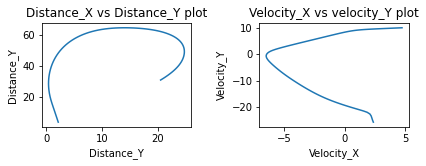

[11] loss: 643.897


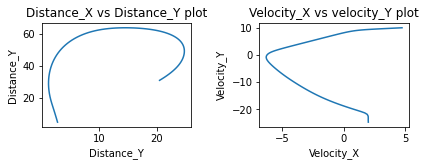

[12] loss: 618.486


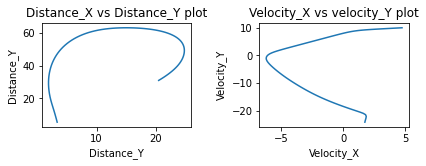

[13] loss: 598.209


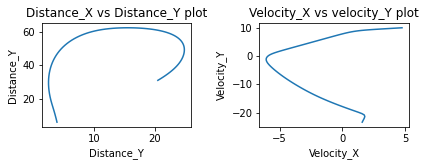

[14] loss: 579.893


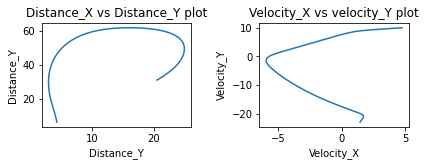

[15] loss: 559.726


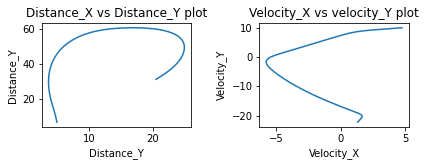

[16] loss: 484.919


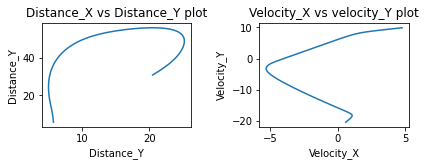

[17] loss: 385.165


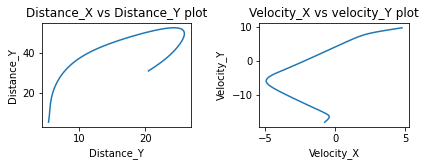

[18] loss: 276.197


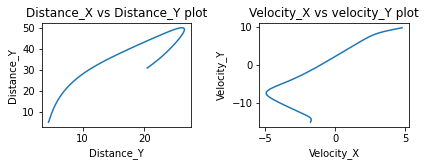

[19] loss: 177.357


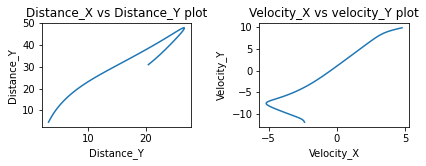

[20] loss: 112.128


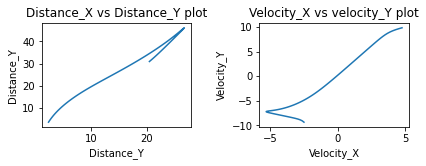

[21] loss: 73.332


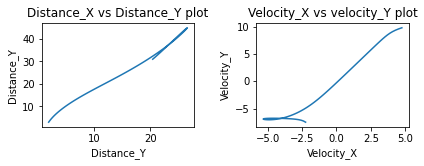

[22] loss: 51.557


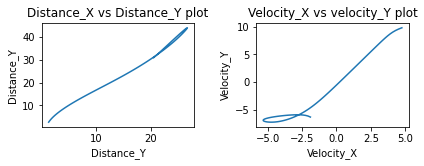

[23] loss: 39.177


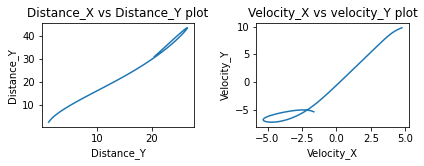

[24] loss: 31.322


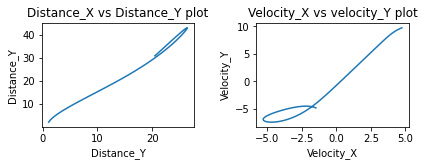

[25] loss: 25.704


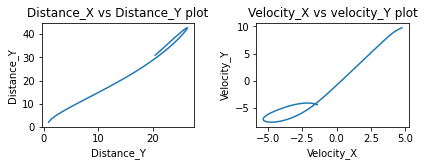

[26] loss: 21.563


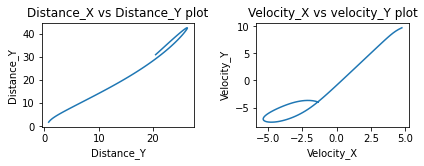

[27] loss: 18.289


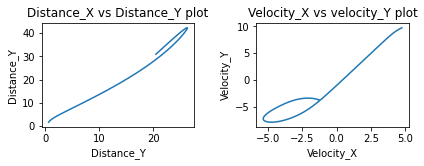

[28] loss: 15.617


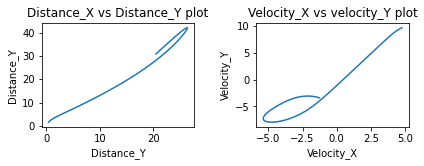

[29] loss: 13.426


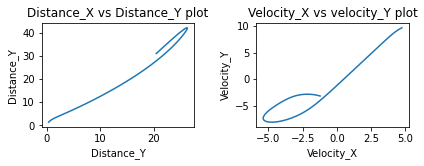

[30] loss: 11.592


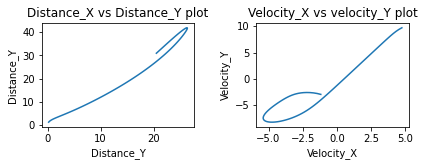

[31] loss: 10.001


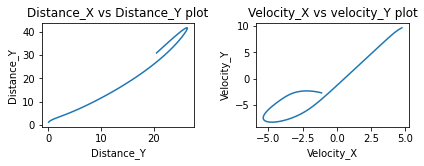

[32] loss: 8.557


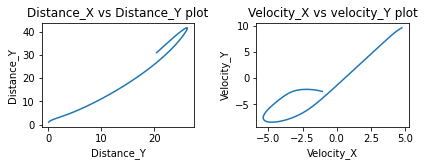

[33] loss: 7.275


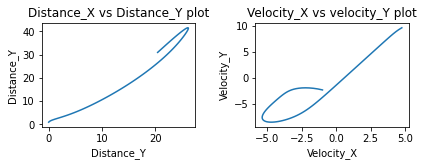

[34] loss: 6.114


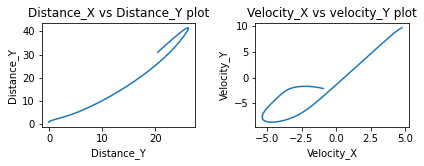

[35] loss: 5.079


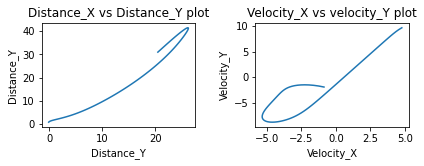

[36] loss: 4.175


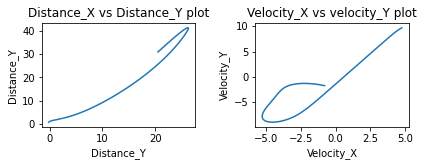

[37] loss: 3.318


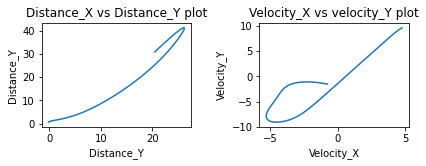

[38] loss: 2.535


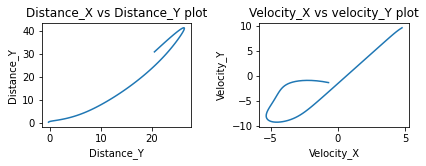

[39] loss: 1.807


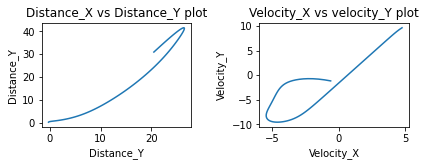

[40] loss: 1.208


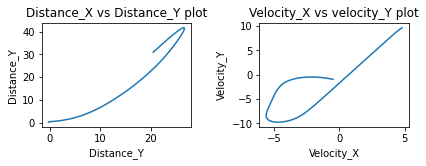

[41] loss: 0.791


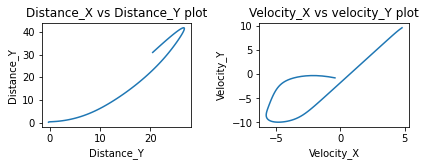

[42] loss: 0.455


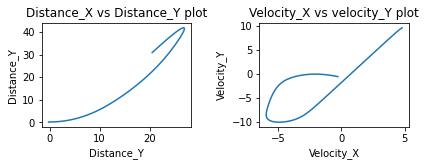

[43] loss: 0.259


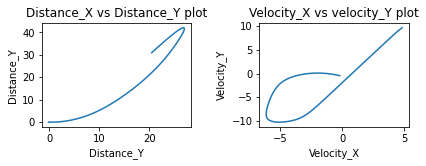

[44] loss: 0.161


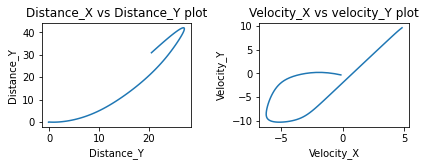

[45] loss: 0.103


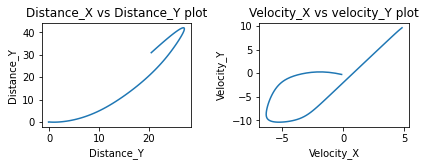

[46] loss: 0.066


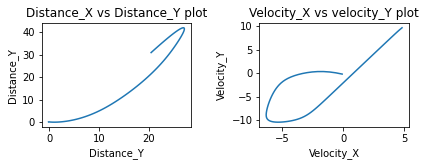

[47] loss: 0.043


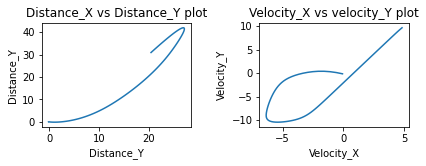

[48] loss: 0.028


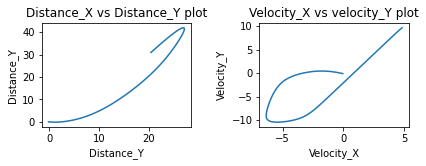

[49] loss: 0.019


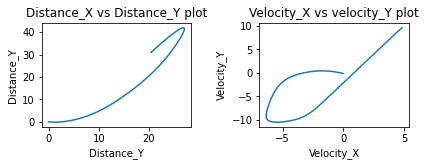

[50] loss: 0.012


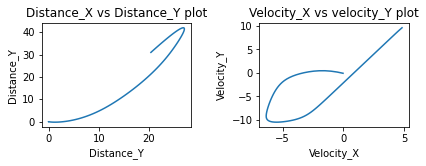

[51] loss: 0.008


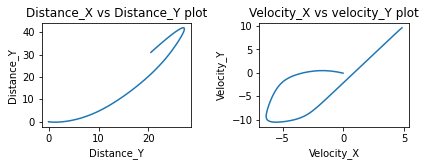

[52] loss: 0.005


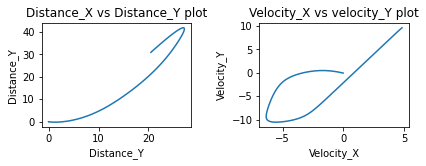

[53] loss: 0.004


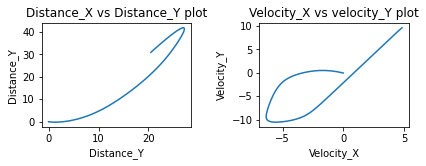

[54] loss: 0.002


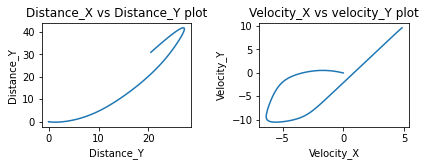

[55] loss: 0.002


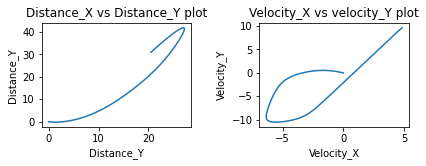

[56] loss: 0.001


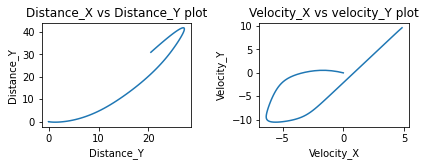

[57] loss: 0.001


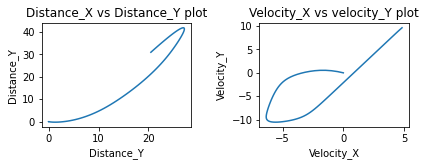

[58] loss: 0.000


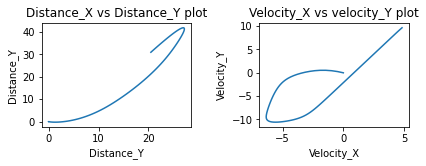

[59] loss: 0.000


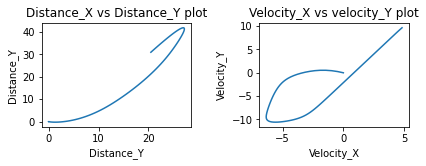

[60] loss: 0.000


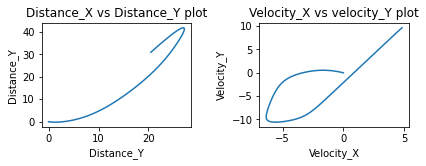

In [7]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4 # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 2 # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(60)  # solve the optimization problem